## Author network analysis

### Inputs

- PAPERS_INFO/PROCESSED/JITS_AUTHORS_PRO

### Outputs

- network and community distributions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from nxviz.plots import CircosPlot
import networkx as nx
from collections import Counter
from itertools import repeat
from networkx.algorithms import community
import community as cl
import matplotlib.cm as cm


In [ ]:
authors = pd.read_csv('../papers_info/processed/jits_authors_pro.csv')
groups = authors.groupby('last_first_pro').count().reset_index()

authors_2paper = groups[groups.paper_id > 1]['last_first_pro']
authors_5paper = groups[groups.paper_id > 5]['last_first_pro']
authors_20paper = groups[groups.paper_id > 20]['last_first_pro']

author20 = authors[authors.paper_id.isin(authors[authors.last_first_pro.isin(authors_20paper)].paper_id)]

In [ ]:
unique_ids = authors.paper_id.unique()
author_links = [{pid:list(combinations(authors[authors.paper_id == pid].last_first_pro.values, 2))} for pid in unique_ids]
author_links = [list(zip(repeat(key, len(item)),item)) for sub in author_links for key, item in sub.items()]
author_links = [(item[0], item[1][0], item[1][1]) for sub in author_links for item in sub]

df = pd.DataFrame(author_links, columns=['paper_id', 'from', 'to'])
df = df.merge(authors, on = 'paper_id')[['paper_id', 'from', 'to', 'year', 'journal']]
df.drop_duplicates(inplace = True)

In [ ]:
start = 2010

plt.figure(figsize=(22,3))
for start in range(2010, 2018):
    end = start + 3
    plt.subplot(1, 8, start-2010+1)
    df_graph = df[(df.year >= start) & (df.year < end)].groupby(['from', 'to']).size().reset_index()
    df_graph.columns = ['from', 'to', 'papers']
    G = nx.from_pandas_edgelist(df_graph, source = "from", target = "to", edge_attr = 'papers')
    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels = False, node_size = 0.1, node_color = 'skyblue', edge_color = 'red', alpha = 1, width = 0.5)
    plt.title('%d - %d' % (start, end))
    start += 1
plt.show()

In [ ]:
journals = ['jits']

for i,j in enumerate(journals):
    plt.subplot(1, 1, i+1)
    df_graph = df[df.journal == j].groupby(['from', 'to']).size().reset_index()
    df_graph.columns = ['from', 'to', 'papers']
    G = nx.from_pandas_edgelist(df_graph, source = "from", target = "to", edge_attr = 'papers')
    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels = False, node_size = 0.1, node_color = 'skyblue', edge_color = 'red', alpha = 1, width = 0.5)
    plt.title(j)
plt.show()

In [ ]:
all_df_graph = df.groupby(['from', 'to']).size().reset_index()
all_df_graph.columns = ['from', 'to', 'papers']
total_graph = nx.from_pandas_edgelist(all_df_graph, source = "from", target = "to", edge_attr = 'papers')

In [ ]:
# degree count

degree_sequence = np.array(sorted([d for n, d in total_graph.degree()], reverse=True))
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.bar(deg, cnt, width=0.80, color="b")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [ ]:
# largest connected community

df_graph = df[df.journal == 'jits'].groupby(['from', 'to']).size().reset_index()
df_graph.columns = ['from', 'to', 'papers']
jits_graph = nx.from_pandas_edgelist(df_graph, source = "from", target = "to", edge_attr = 'papers')

gcc = sorted(nx.connected_components(jits_graph), key = len, reverse = True)
jits_top_graph = jits_graph.subgraph(gcc[0])

labels = [v if groups[groups.last_first_pro == v].iloc[0,1] > 10 else "" for v in list(jits_top_graph.nodes())]
labels = {k:v for k,v in zip(list(jits_top_graph.nodes()), labels)}
sizes = [groups[groups.last_first_pro == v].iloc[0,1] * 5 for v in list(jits_top_graph.nodes())]

plt.figure(figsize=(8,6))
nx.draw_networkx(jits_top_graph, pos=nx.spring_layout(jits_top_graph), labels = labels, node_size = sizes, node_color = 'skyblue', edge_color = 'red', alpha = 1, width = 0.5)

In [ ]:
# Communities

mapping = {v: k for k, v in enumerate(groups.last_first_pro.values)}
partition = cl.best_partition(jits_graph)
labels = [mapping[v] if groups[groups.last_first_pro == v].iloc[0,1] > 20 else "" for v in partition.keys()]
labels = {k:v for k,v in zip(partition.keys(), labels)}
sizes = [groups[groups.last_first_pro == v].iloc[0,1] * 2 for v in partition.keys()]

# draw the graph
pos = nx.spring_layout(jits_graph)
# color the nodes according to their partition
plt.figure(figsize=(18,18))
cmap = cm.get_cmap('spring', max(partition.values()) + 1)
nx.draw_networkx(jits_graph, pos, labels = labels, nodelist = partition.keys(), node_size = sizes, font_size = 14, cmap = cmap, edge_color = 'gray', node_color = list(partition.values()))
plt.show()

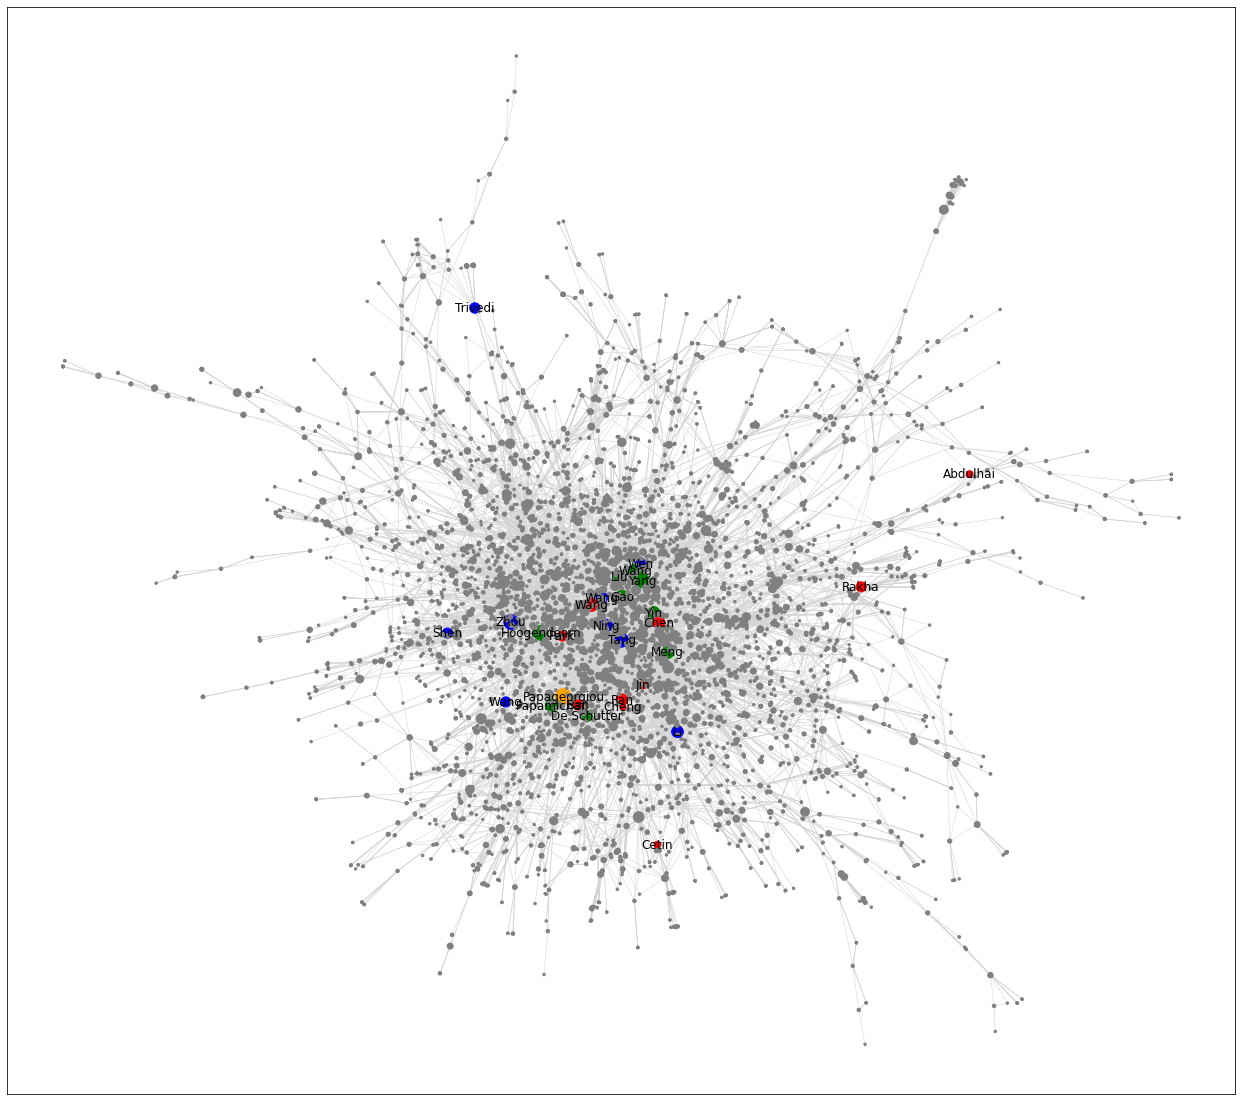

In [105]:
top_authors = authors.groupby(['journal', 'last_first_pro']).count().reset_index().sort_values(by = ['journal', 'paper_id'], ascending=False)

jits_tops = top_authors[top_authors.journal == 'jits'].iloc[:10].last_first_pro.values
tits_tops = top_authors[top_authors.journal == 'tits'].iloc[:10].last_first_pro.values
trc_tops = top_authors[top_authors.journal == 'trc'].iloc[:10].last_first_pro.values

tops = {author: 'red' for author in jits_tops}
tops.update({author: 'blue' for author in tits_tops})
tops.update({author: 'green' for author in trc_tops})
tops['Papageorgiou, Markos'] = 'orange'


# largest community
gcc = sorted(nx.connected_components(total_graph), key = len, reverse = True)
top_graph = total_graph.subgraph(gcc[0])

labels = [v.split(",")[0] if v in tops else "" for v in list(top_graph.nodes())]
labels = {k:v for k,v in zip(list(top_graph.nodes()), labels)}

sizes = [groups[groups.last_first_pro == v].iloc[0,1] * 6 for v in list(top_graph.nodes())]
colors= [tops[v] if v in tops else 'gray' for v in list(top_graph.nodes())]

plt.figure(figsize=(15, 15))
nx.draw_networkx(top_graph, pos=nx.spring_layout(top_graph), labels = labels, node_size = sizes, node_color = colors, edge_color = 'lightgray', alpha = 1, width = 0.5)

In [ ]:
# Limit to TOP 50 authors
# top50authors = pd.DataFrame.from_records(Counter(author10.last_first_pro).most_common(50), columns=["Name", "Count"])

# top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

# G_50 = G.subgraph(top50_nodes)

# for n in G_50.nodes():
#     G_50.nodes[n]["papers"] = int(top50authors[top50authors["Name"] == n]["Count"])
#     journals = author10[author10['last_first_pro'] == n].groupby('journal').count().reset_index().sort_values(by = 'paper_id', ascending = False)
#     G_50.nodes[n]["journal"] = ".".join(journals.journal.values)

# c = CircosPlot(G_50, dpi=600, node_grouping ="journal",  edge_width="Count",  figsize=(10, 10),  node_color="journal", node_labels=True, node_label_layout='numbers', group_label_color = True, group_label_offset = 13, group_label_position = 'end')
# c.draw()
# plt.show()